In [58]:
import bz2
from tqdm import tqdm
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SpatialDropout1D,Embedding
from keras.callbacks import ModelCheckpoint

import nltk
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from PIL import Image
from wordcloud import WordCloud

In [8]:
output_path='train.ft.txt'
with bz2.open('train.ft.txt.bz2', 'rt', encoding='utf-8') as compressed_file, open(output_path, 'w', encoding='utf-8') as output_file:
    for line in compressed_file:
        output_file.write(line)
    print('Train Successful ❤')
output_path='test.ft.txt'
with bz2.open('test.ft.txt.bz2', 'rt', encoding='utf-8') as compressed_file, open(output_path, 'w', encoding='utf-8') as output_file:
    for line in compressed_file:
        output_file.write(line)
    print('Test Successful ❤')

Train Successful ❤
Test Successful ❤


In [169]:
train, test, train_label, test_label = [], [], [], []

with open('train.ft.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()
for line in tqdm(lines):
    train.append(line.split('__label__')[1][1:])
    train_label.append(line.split('__label__')[1][0])

with open('test.ft.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()
for line in tqdm(lines):
    test.append(line.split('__label__')[1][1:])
    test_label.append(line.split('__label__')[1][0])

# Convert lists to DataFrames
train_df = pd.DataFrame({'text': train, 'label': train_label}).sample(36000)
test_df = pd.DataFrame({'text': test, 'label': test_label}).sample(4000)

100%|██████████| 400000/400000 [00:00<00:00, 1114107.08it/s]


In [174]:
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [175]:
def preprocess_text(text):

    english_words = set(words.words())
    stopword = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    def remove_patterns(input_txt, patterns):
        for pattern, repl in patterns:
            input_txt = re.sub(pattern, repl, input_txt)
        return input_txt

    def lemmatize(tokens):
        return [lemmatizer.lemmatize(token) for token in tokens if token not in stopword]

    text = str(text).lower()

    # Replace unwanted patterns
    patterns = [
        ('\[.*?\]', ''),
        ('https?://\S+|www\.\S+', ''),
        ('<.*?>+', ''),
        (r"\@w+|\#", ''),
        (r"[^\w\s]", ''),
        (f'[{re.escape(string.punctuation)}]', ''),
        ('\n', ''),
        ('\w*\d\w*', ''),
    ]
    text = remove_patterns(text, patterns)

    # Tokenize and lemmatize
    tokens = word_tokenize(text)
    lemmatized_tokens_set = set(tokens)
    exist_words_set = lemmatized_tokens_set.intersection(english_words)

    # If you need the result as a list
    exist_words = list(exist_words_set)
    return " ".join(exist_words)


train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

Text(0.5, 1.0, 'Distribution of sentiments')

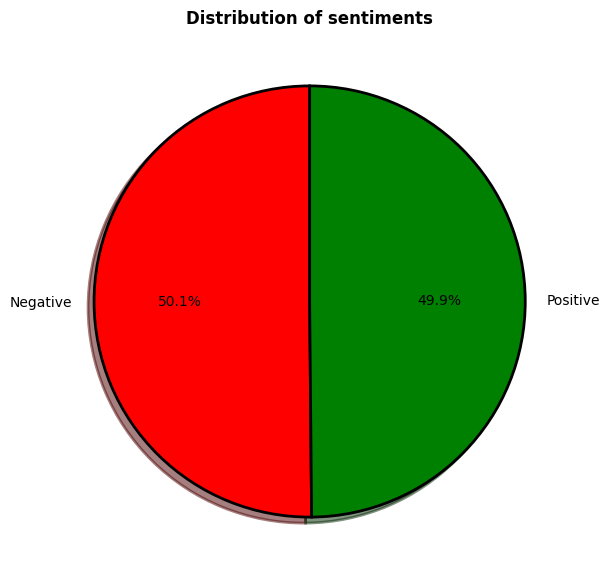

In [47]:
# visualizing data using piechart
fig = plt.figure(figsize=(7,7))
colors = ('red', 'green')
wp = {'linewidth':2, "edgecolor":'black'}
tags = train_df['label'].map({'1': 'Negative', '2': 'Positive'}).value_counts()
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, label='')
plt.title("Distribution of sentiments", fontweight='bold')

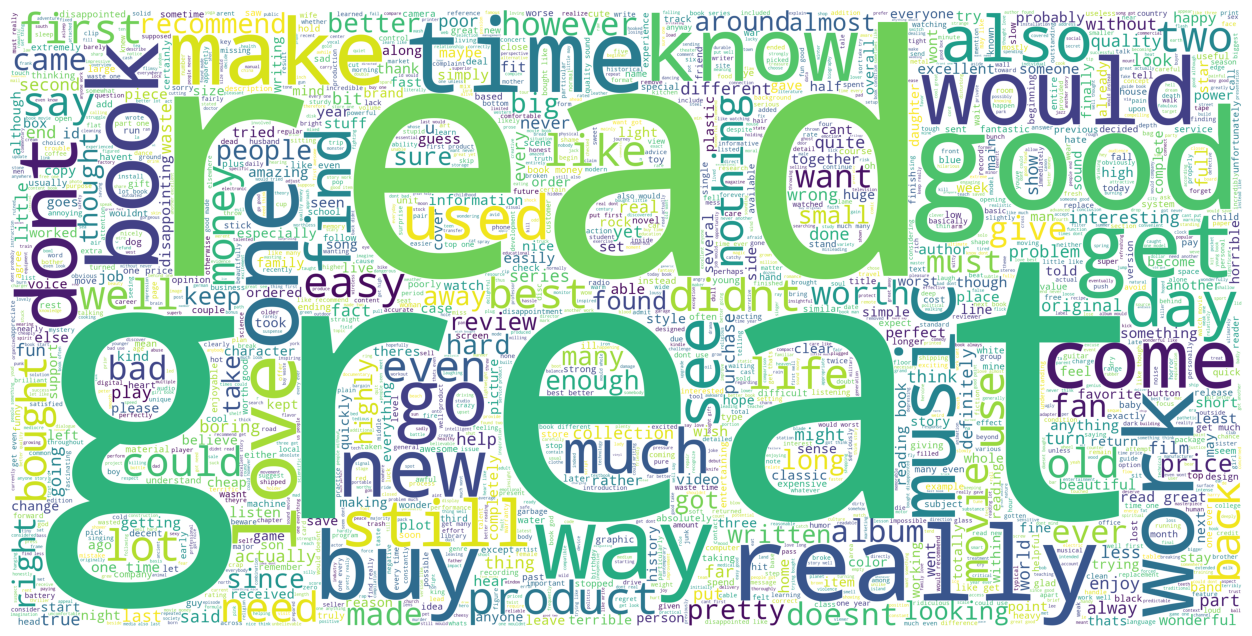

In [176]:
def plot_wordcolund(df):
    
    words = " ".join(df['text'])
    stopword = set(stopwords.words('english'))
    wordcloud = WordCloud(stopwords=stopword, background_color='white', max_words=2000, height = 2000, width=4000).generate(words)
    plt.figure(figsize = (16,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

plot_wordcolund(train_df)

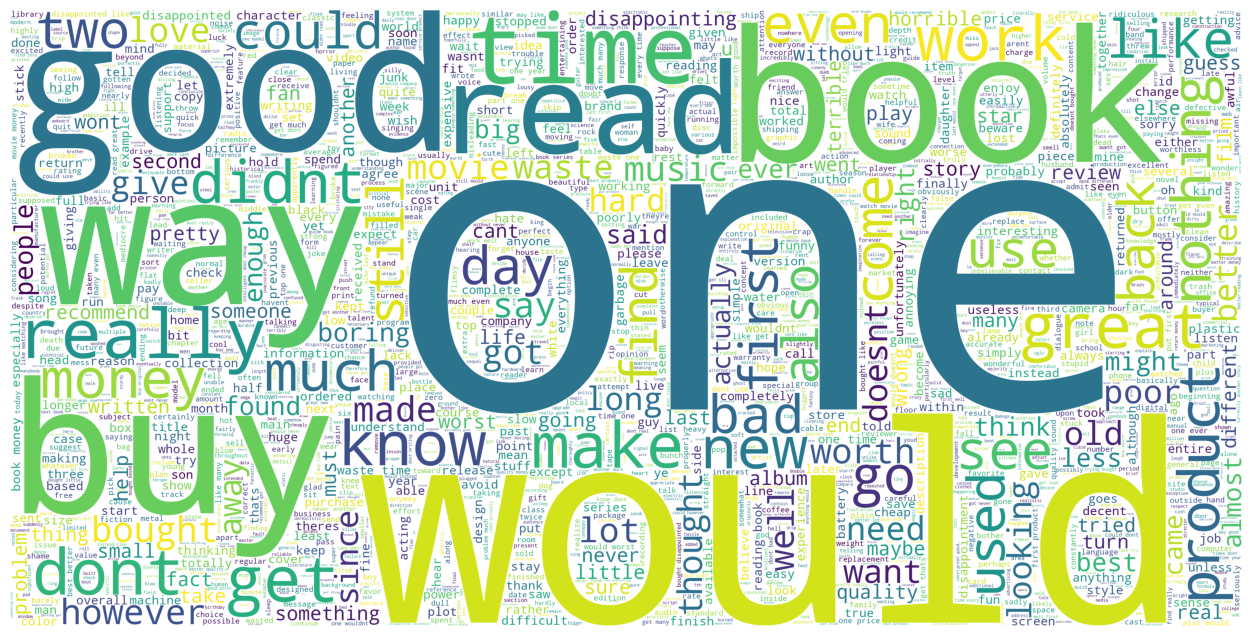

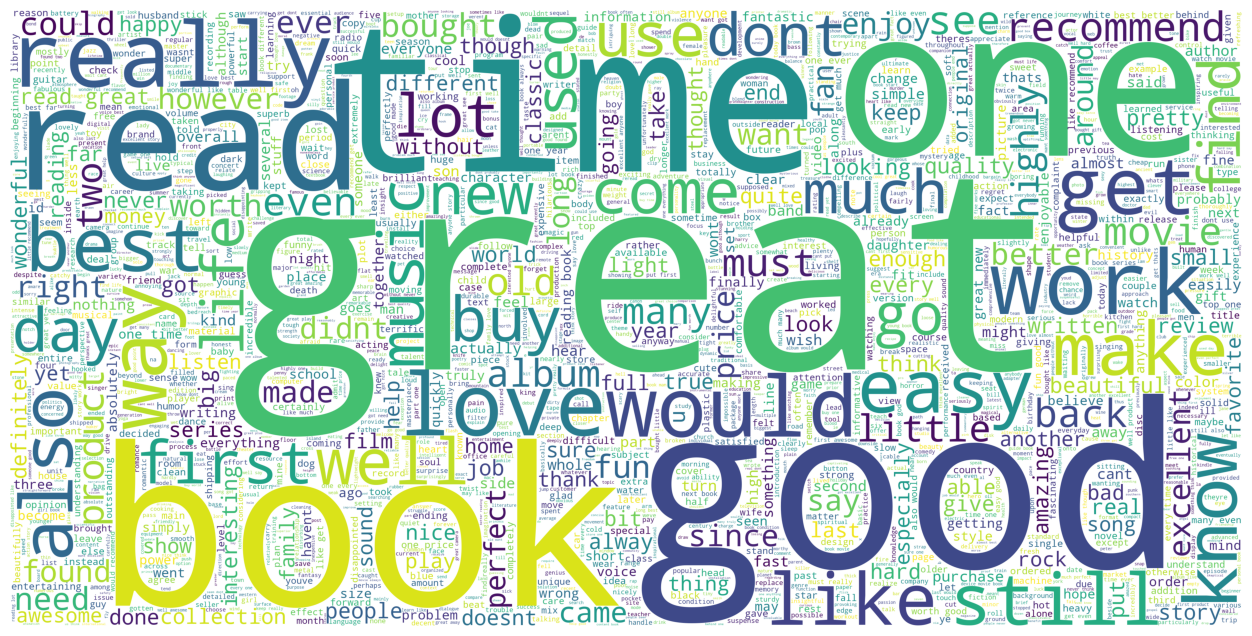

In [177]:
plot_wordcolund(train_df.query("label == '1'"))
plot_wordcolund(train_df.query("label == '2'"))

In [188]:
pd.concat([train_df, test_df], axis=0).reset_index(drop=True).rename(columns={'label': 'sentiment'}).replace({'1': 'Negative', '2': 'Positive'}).to_excel('amazon_reviews.xlsx')

In [179]:
X_train, y_train = train_df['text'], train_df['label']
X_test, y_test = test_df['text'], test_df['label']

cvec = TfidfVectorizer(analyzer=lambda x:x.split(' '))
cvec.fit_transform(X_train)
cvec.vocabulary_

{'hold': 8769,
 'broke': 2307,
 'first': 7044,
 'after': 353,
 'product': 14371,
 'stand': 17856,
 'warranty': 21030,
 'bowl': 2147,
 'cheese': 3033,
 'to': 19280,
 'is': 9927,
 'time': 19220,
 'its': 9956,
 'would': 21533,
 'plastic': 13769,
 'with': 21411,
 'by': 2500,
 'problem': 14348,
 'up': 20520,
 'grating': 8097,
 'the': 19003,
 'working': 21502,
 'customer': 4516,
 'cheap': 3006,
 'this': 19093,
 'unit': 20233,
 'support': 18438,
 'not': 12446,
 'extremely': 6662,
 'or': 12767,
 'popular': 13992,
 'relationship': 15316,
 'when': 21216,
 'book': 2039,
 'i': 9075,
 'small': 17229,
 'phrase': 13598,
 'was': 21037,
 'lived': 10757,
 'my': 12053,
 'wish': 21395,
 'like': 10657,
 'many': 11156,
 'even': 6419,
 'advice': 303,
 'out': 12856,
 'know': 10277,
 'diamond': 5080,
 'do': 5479,
 'now': 12484,
 'in': 9290,
 'valley': 20638,
 'had': 8318,
 'level': 10579,
 'think': 19078,
 'chapter': 2958,
 'given': 7853,
 'string': 18141,
 'are': 921,
 'how': 8930,
 'must': 12032,
 'gave': 77

In [185]:
# import dill as pickle

# To save the model:
# with open('logistic_regression_model.pkl', 'wb') as f:
    # pickle.dump(lr, f)

# To load the model:
# with open('tfidf_vectorizer.pkl', 'wb') as f:
    # pickle.dump(cvec, f)

In [180]:
from sklearn.linear_model import LogisticRegression

train_bow = cvec.transform(X_train)
lr = LogisticRegression()
lr.fit(train_bow, y_train)

test_bow = cvec.transform(X_test)
test_predictions = lr.predict(test_bow)
print(classification_report(test_predictions, y_test))

              precision    recall  f1-score   support

           1       0.86      0.88      0.87      1993
           2       0.87      0.86      0.87      2007

    accuracy                           0.87      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.87      0.87      0.87      4000



In [181]:
from sklearn.metrics.pairwise import cosine_similarity

train_bow = cvec.transform(X_train)

def classify_using_cosine(test_vector):
    # compute cosine similarities 
    similarities = cosine_similarity(test_vector, train_bow)

    # Get the index 
    most_similar_idx = np.argmax(similarities)

    # Return the label of the most similar
    return y_train.iloc[most_similar_idx]

# predict labels
test_bow = cvec.transform(X_test)
y_pred = [classify_using_cosine(test_vector) for test_vector in test_bow]

# classification report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           1       0.64      0.72      0.68      1819
           2       0.74      0.67      0.70      2181

    accuracy                           0.69      4000
   macro avg       0.69      0.69      0.69      4000
weighted avg       0.70      0.69      0.69      4000



In [182]:
train_bow = cvec.transform(X_train)

def jaccard_similarity(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2))

def classify_using_jaccard(test_vector):
    # Convert the bag-of-words vectors to sets
    test_set = set(test_vector.indices)
    jaccard_scores = [jaccard_similarity(test_set, set(train_vector.indices)) for train_vector in train_bow]
    
    # Get the index of the highest jaccard similarity
    most_similar_idx = np.argmax(jaccard_scores)
    
    # Return the label of the most similar
    return y_train.iloc[most_similar_idx]

# Predict labels
test_bow = cvec.transform(X_test)
y_pred = [classify_using_jaccard(test_vector) for test_vector in test_bow]

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.71      0.61      0.65      2028
           2       0.65      0.74      0.69      1972

    accuracy                           0.67      4000
   macro avg       0.68      0.67      0.67      4000
weighted avg       0.68      0.67      0.67      4000



In [184]:
def classify_sentiment(scores):
    return "2" if scores['compound'] >= 0.05 else "1"

# Add sentiment scores
# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
y_pred = test_df['text'].apply(lambda x: classify_sentiment(sia.polarity_scores(x)))
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.83      0.50      0.63      2028
           2       0.64      0.89      0.74      1972

    accuracy                           0.70      4000
   macro avg       0.73      0.70      0.68      4000
weighted avg       0.73      0.70      0.68      4000

